# 1. Setup

In [1]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from utils import *

# 2. Prepare data

## 2.1. Load data

In [2]:
trips = pd.read_parquet('data/trips.parquet').disp()

747,088 rows x 21 cols; Memory: 34.9 MiB


,Distance,Time,Speed,Weight,Purpose,Mode,Weekend,GasPrice,StayTime,StartTime,...,Region,Age,Sex,Race,Hispanic,Education,Worker,Income,HomeOwn,VehOwn
,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>
0,8.439379,16.182075,31.291583,1.0,HBO,Drive,No,Low,Long,Off-peak,...,South,Senior,Female,Non-White,No,College,No,Mid,Own,High


## 2.2. Create SES groups

In [3]:
trips['SES'] = 'Mid'
trips.loc[trips.pipe(lambda df: (
    + (df.Age == 'Senior').astype(int)
    + (df.Worker == 'No').astype(int)
    + (df.Race == 'Non-White').astype(int)
    + (df.Income == 'Low').astype(int)
    + (df.HomeOwn == 'Rent').astype(int)
    + (df.VehOwn == 'Low').astype(int)
) >= 5), 'SES'] = 'Low'
trips.loc[trips.pipe(lambda df: (
    + (df.Age.isin(['Young', 'Mid'])).astype(int)
    + (df.Worker == 'Yes').astype(int)
    + (df.Race == 'White').astype(int)
    + (df.Income.isin(['Mid', 'High'])).astype(int)
    + (df.HomeOwn == 'Own').astype(int)
    + (df.VehOwn.isin(['Mid', 'High'])).astype(int)
) >= 5), 'SES'] = 'High'
trips.SES = pd.Categorical(trips.SES, categories=['Low', 'Mid', 'High'])
trips.SES.value_counts()

SES
High    398603
Mid     333528
Low      14957
Name: count, dtype: int64

## 2.3. Finalize and export

In [4]:
# trips['LongStay'] = U.factor((trips.StayTime == 'Very long')
#                              .map({True: 'Yes', False: 'No'}))
# trips['Purpose'] = trips.Purpose.map(D(
#         HBW='Work', HBSHOP='Shopping', HBSOC='Other', HBO='Other'))
# trips = trips.query('ODUrban != "R ↔ U"').dropna().reset_index(drop=1)
# trips.ODUrban = trips.ODUrban.cat.remove_unused_categories()
trips['Purpose'] = (trips.Purpose == 'HBW').map({True: 'Work', False: 'Non-work'})
trips.Purpose = pd.Categorical(trips.Purpose, categories=['Work', 'Non-work'])
trips = trips[['Distance', 'Time', 'Speed', 'Mode', 'Purpose', 'Urbanity', 'SES']].disp()
trips.to_parquet('data/trips2.parquet')

747,088 rows x 7 cols; Memory: 20.0 MiB


,Distance,Time,Speed,Mode,Purpose,Urbanity,SES
,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>
0,8.439379,16.182075,31.291583,Drive,Non-work,S → S,Mid


# 3. Fit parameters

In [5]:
def fit_imped_func(func, vals, vmax):
    y = Series(vals).clip(0, vmax)
    y, x = np.histogram(y, bins=np.arange(0, vmax + 1))
    x, y = x[1:], (1 - (y / y.sum()).cumsum()).clip(0)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        params = curve_fit(func, x, y)[0]
    yfit = func(x, *params).clip(0, 1)
    r2 = r2_score(y, yfit)
    params = {f'β{i+1}': x for i, x in enumerate(params)}
    return params | D(r2=r2)

x = fit_imped_func(lambda x, a: np.exp(a * x), trips.Distance, 100); x

{'β1': np.float64(-0.10377313734214878), 'r2': 0.9722571547195505}

## 3.1. Single-parameter

In [6]:
coef1 = []
for (fname, func), (target, vmax) in it.product([
    ('Base exponential', lambda x, a: np.exp(-a * x)),
    ('Power exponential', lambda x, a, b: np.exp(-a * (x ** b))),
], [('Distance', 100), ('Time', 120)]):
    overall = fit_imped_func(func, trips[target], vmax)
    coef1.append(D(factor='Overall', level='', func=fname,
                target=target) | overall)
    for factor in trips.select_dtypes(CAT).columns:
        for level, df in trips.groupby(factor):
            fits = fit_imped_func(func, df[target], vmax)
            coef1.append(D(factor=factor, level=level,
                           func=fname, target=target) | fits)
coef1 = Pdf(coef1).drop(columns='r2')
coef1.factor = U.factor(coef1.factor)
coef1.level = U.factor(coef1.level)
coef1 = coef1.melt(['target', 'func', 'factor', 'level']).disp(0)
coef1.pivot_table('value', ['factor', 'level'], [
    'func', 'target', 'variable'])

128 rows x 6 cols; Memory: 0.0 MiB


,target,func,factor,level,variable,value
,<object>,<object>,<category>,<category>,<object>,<float64>


func              Base exponential           Power exponential            \
target                    Distance      Time          Distance             
variable                        β1        β1                β1        β2   
factor   level                                                             
Overall                   0.103773  0.053918          0.186364  0.764821   
Mode     Drive            0.093689  0.054819          0.146403  0.826583   
         Transit          0.068864  0.019987          0.095342  0.887126   
         Walk             1.079606  0.059946          1.173653  0.749212   
         Bike             0.276203  0.045774          0.332796  0.871110   
Purpose  Work             0.054606  0.038162          0.051442  1.019025   
         Non-work         0.120068  0.057694          0.209672  0.760833   
Urbanity U → U            0.222133  0.063251          0.374360  0.692484   
         S → S            0.131766  0.062023          0.222266  0.765208   
         R → R            0.100489  0.059547          0.201488  0.729209   
         U ↔ S            0.084798  0.047322          0.093808  0.961689   
         S ↔ R            0.047993  0.038794          0.029596  1.150505   
         R ↔ U            0.037940  0.032077          0.015334  1.264268   
SES      Low              0.180249  0.040708          0.320681  0.708987   
         Mid              0.122944  0.055244          0.214902  0.758532   
         High             0.090436  0.052877          0.159500  0.784504   

func                                   
target                 Time            
variable                 β1        β2  
factor   level                         
Overall            0.022688  1.282219  
Mode     Drive     0.019468  1.339882  
         Transit   0.001333  1.678955  
         Walk      0.058199  1.009813  
         Bike      0.023316  1.209078  
Purpose  Work      0.008365  1.443685  
         Non-work  0.023668  1.297793  
Urbanity U → U     0.033462  1.220136  
         S → S     0.027285  1.280976  
         R → R     0.038410  1.146435  
         U ↔ S     0.010375  1.479050  
         S ↔ R     0.005855  1.559027  
         R ↔ U     0.002706  1.695537  
SES      Low       0.017938  1.244231  
         Mid       0.022762  1.292084  
         High      0.022457  1.276877

In [7]:
coef1.to_csv('data/impedance_params_single.csv', index=False)

## 3.2. Double-parameter

In [8]:
coef2 = []
func = lambda x, a, b: np.exp(a * (x ** b)) # power exponential
for (mode, purp), df in trips.groupby(['Mode', 'Purpose']):
    fits = fit_imped_func(func, df['Time'], 120)
    coef2.append(D(mode=mode, purpose=purp) | fits)
coef2 = Pdf(coef2).disp(None)

8 rows x 5 cols; Memory: 0.0 MiB


,mode,purpose,β1,β2,r2
,<object>,<object>,<float64>,<float64>,<float64>
0,Drive,Work,-0.007127,1.501453,0.998159
1,Drive,Non-work,-0.020097,1.36163,0.995175
2,Transit,Work,-0.000166,2.096192,0.999184
3,Transit,Non-work,-0.002062,1.608027,0.998069
4,Walk,Work,-0.053588,1.085346,0.997923
5,Walk,Non-work,-0.058269,1.007449,0.997875
6,Bike,Work,-0.007653,1.591415,0.994467
7,Bike,Non-work,-0.02808,1.145222,0.991943


In [9]:
coef2.to_csv('data/impedance_params_double.csv', index=False)

## 3.3. All combinations

In [10]:
coef_all = []
func = lambda x, a, b: np.exp(a * (x ** b)) # power exponential
data = trips.copy()
data.Urbanity = data.Urbanity.map({
        'U → U': 'U → U', 'S → S': 'U → U',
        'R → R': 'R → R', 'U ↔ S': 'U → U',
        'S ↔ R': 'R ↔ U', 'R ↔ U': 'R ↔ U'})
data.SES = data.SES.str.replace('Mid', 'High')
grp_cols = ['Mode', 'Purpose', 'Urbanity', 'SES']
for grp, df in data.groupby(grp_cols):
    if len(df) < 100: continue
    fits = fit_imped_func(func, df['Time'], 120)
    coef_all.append(D(zip(grp_cols, grp)) | D(n=len(df)) | fits)
coef_all = Pdf(coef_all).set_index(grp_cols)
coef_all

n        β1        β2        r2
Mode    Purpose  Urbanity SES                                       
Drive   Work     R → R    High    9106 -0.020460  1.276268  0.998953
                 R ↔ U    High   17224 -0.002086  1.770357  0.997447
                 U → U    High   71629 -0.007588  1.494419  0.997740
        Non-work R → R    High   55950 -0.035339  1.203348  0.996365
                 R ↔ U    High   72070 -0.005782  1.562887  0.995410
                 U → U    High  436738 -0.019117  1.414948  0.995068
                          Low      798 -0.012084  1.434360  0.994043
Transit Work     U → U    High    3295 -0.000157  2.111002  0.999162
        Non-work R → R    High     454 -0.002759  1.602659  0.998536
                 R ↔ U    High     508 -0.001545  1.677081  0.996747
                 U → U    High    7706 -0.002048  1.606564  0.998106
                          Low      310 -0.001865  1.627237  0.996335
Walk    Work     R → R    High     474 -0.152396  0.954883  0.987076
                 U → U    High    2280 -0.035829  1.187525  0.997904
        Non-work R → R    High    7480 -0.058156  0.943646  0.997850
                 R ↔ U    High     302 -0.018107  1.285700  0.997556
                 U → U    High   54210 -0.057230  1.024553  0.997461
                          Low      411 -0.026328  1.216861  0.997809
Bike    Work     U → U    High    1016 -0.005977  1.658970  0.993457
        Non-work R → R    High     390 -0.027766  1.055061  0.997306
                 R ↔ U    High     225 -0.001803  1.650510  0.998154
                 U → U    High    4133 -0.025792  1.201906  0.990562

# 4. Visualize

## 4.1. Distributions

  0%|          | 0/3 [00:00<?, ?it/s]

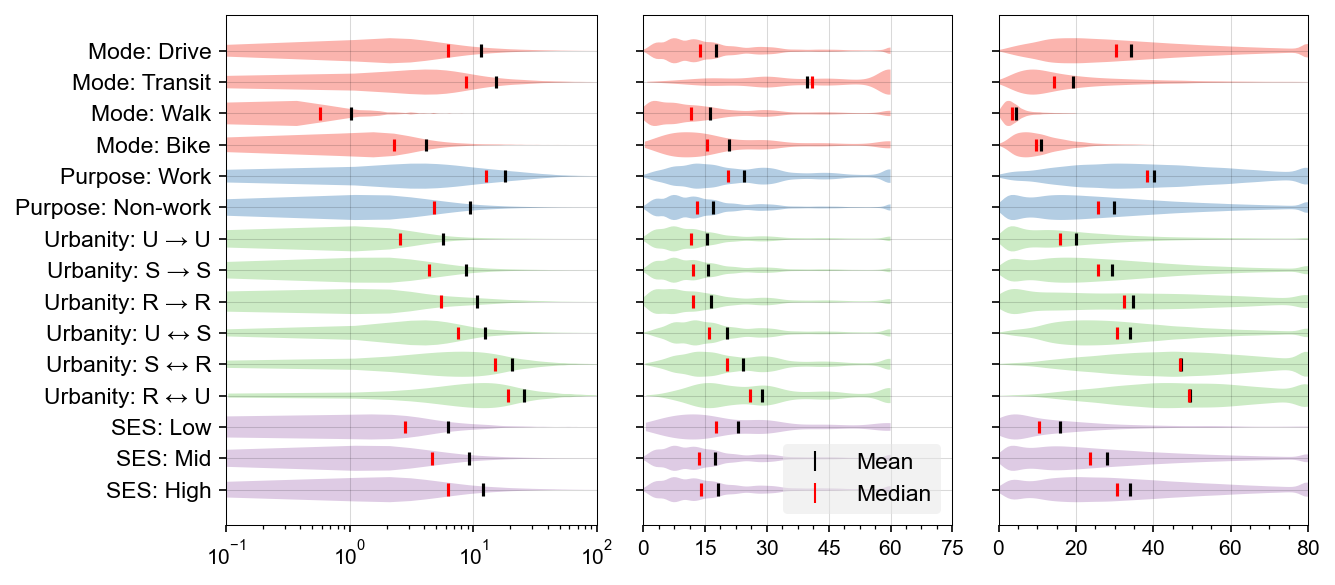

In [11]:
def fig_final_vars_distr(trips=trips, dpi=150, cmap='Pastel1'):
    _, axes = plt.subplots(1, 3, figsize=(9, 4), dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    ticker = mpl.ticker.EngFormatter(places=1)
    factors = list(trips.select_dtypes(CAT).columns)
    colors = D(zip(factors, sns.color_palette(cmap, len(factors)).as_hex()))
    for j, (var, rng) in enumerate(tqdm([('Distance', (0.1, 100)),
                                         ('Time', (0, 60)),
                                         ('Speed', (0, 80))])):
        df = Pdf(sum([[D(col=col, cat=x[0], label=col + ': ' + x[0],
                         vals=x[1].values, n=ticker(len(x[1])))
                       for x in trips.groupby(col)[var]]
                      for col in factors], []))
        df.vals = [x.clip(*rng) for x in df.vals]
        df['color'] = df.col.map(colors)
        ax = plot(axes[j], xlog=var == 'Distance', yminor=0, xlim=rng)
        x = ax.violinplot(list(df.vals), positions=np.arange(len(df)),
                          vert=False, widths=0.8,
                          showextrema=False, showmeans=True, showmedians=True)
        for line, color in zip(x['bodies'], df.color):
            line.set_alpha(1)
            line.set_facecolor(color)
            line.set_linewidth(0)
        x['cmeans'].set_edgecolor('k')
        x['cmedians'].set_edgecolor('r')
        ax.invert_yaxis()
        ax.set_yticks(np.arange(len(df)), df.label, fontsize=11)
        if var == 'Time': ax.set_xticks(np.arange(0, 75+1, 15))
        if j != 0: ax.set_yticklabels([])
        if j == 1:
            ax.legend(loc='lower right', handles=[
                mpl.lines.Line2D([0], [0], label=k, color=v,
                                 marker='|', markersize=10, lw=0)
                for k, v in [('Mean', 'k'), ('Median', 'r')]])
    plt.tight_layout()
    imsave('Distributions of finalized variables')

fig_final_vars_distr(dpi=150) # 30s

## 4.2. Impedance by SES

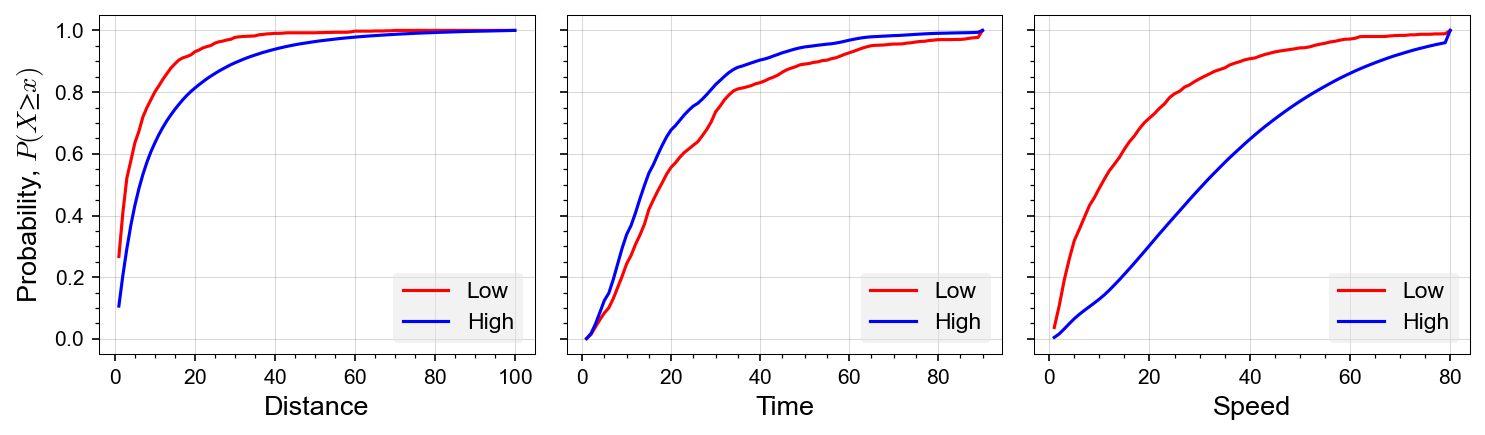

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150, sharey=True)
for i, target, vmax in [(0, 'Distance', 100), (1, 'Time', 90), (2, 'Speed', 80)]:
    ax = plot(axes[i], xlab=target, ylab='Probability, $P(X≥x)$' if i == 0 else '')
    for lab, color in [('Low', 'r'), ('High', 'b')]:
        y = filt(trips, SES=lab)[target].clip(0, vmax)
        y, x = np.histogram(y, bins=np.arange(0, vmax+1))
        ax.plot(x[1:], (y / y.sum()).cumsum(), label=lab, color=color)
    ax.legend()
plt.tight_layout()
imsave('CDF of impedance variables by SES')

## 4.3. Correlation

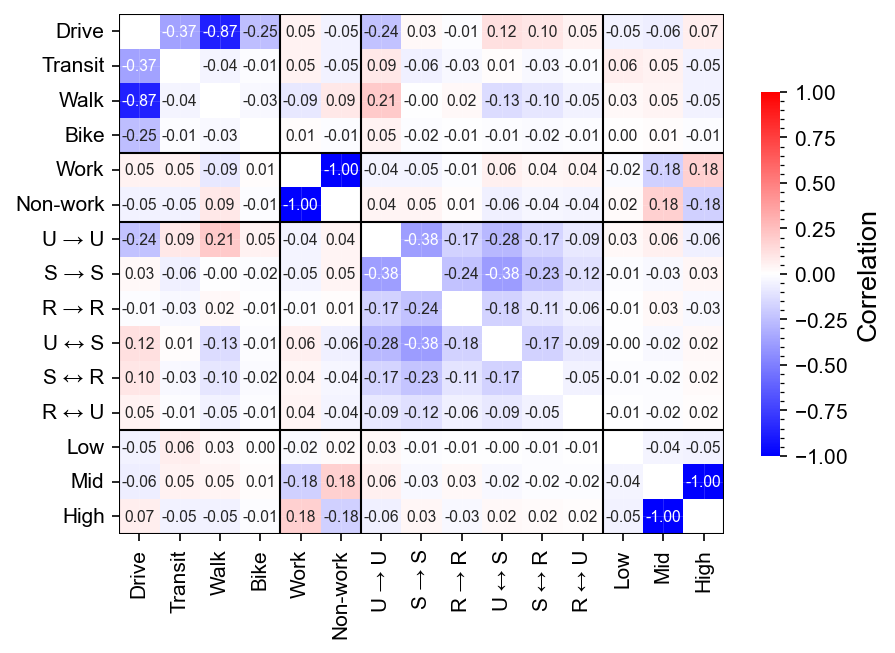

In [13]:
def plot_corr_final_vars(trips=trips, size=(6.5, 4.5), dpi=150, cmap='bwr'):
    X = pd.get_dummies(trips.select_dtypes(CAT), prefix_sep='__')
    corr = X.corr()
    np.fill_diagonal(corr.values, np.nan)
    ax = plot(size=size, dpi=dpi, xminor=0, yminor=0, gridcolor='#ffff')
    labels = [x.split('__')[1] for x in X.columns]
    ax = sns.heatmap(corr, ax=ax, cmap=cmap, vmin=-1, vmax=1,
                     xticklabels=labels, yticklabels=labels,
                     cbar=True, cbar_kws=D(shrink=0.7, label='Correlation'),
                     annot=True, fmt='.2f', annot_kws=D(fontsize=7.5))
    cols = Pdf(D(col=X.columns))
    cols['feat'] = cols.col.str.split('__').str[0]
    cols['idx'] = (cols.feat.astype(CAT).cat.codes.diff() != 0)
    for x in list(cols.idx[cols.idx].index) + [len(cols)]:
        ax.axvline(x, color='k', lw=1)
        ax.axhline(x, color='k', lw=1)
    imsave('Correlation of finalized variables')

plot_corr_final_vars(dpi=150)